In [65]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_d00eb012bbc8456f8bc0d33532832ebc(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage V3 using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '0ec6d687afcb4af79c9da74e26d1179f')
    hconf.set(prefix + '.username', '048d49e7475b4bc48f5f5e7ec9eb4074')
    hconf.set(prefix + '.password', 'xs/B6E9}l/8C?Vmx')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', True)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_d00eb012bbc8456f8bc0d33532832ebc(name)

df_data_1 = sqlContext.read.format('com.databricks.spark.csv')\
  .options(header='true', inferschema='true')\
  .load("swift://BigDataFinalProject." + name + "/ThyroidCleanedData3.csv")
df_data_1.take(5)


[Row(age=72, TSH=30.0, T3=0.6, TT4=15.0, T4U=1.48, FTI=10.0, on_thyroxine=u'f', query_on_thyroxine=u'f', thyroid_surgery=u'f', query_hypothyroid=u'f', query_hyperthyroid=u'f', pregnant=u'f', sick=u'f', goitre=u'f', Result=u'hypothyroid'),
 Row(age=15, TSH=145.0, T3=1.7, TT4=19.0, T4U=1.13, FTI=17.0, on_thyroxine=u't', query_on_thyroxine=u'f', thyroid_surgery=u'f', query_hypothyroid=u'f', query_hyperthyroid=u'f', pregnant=u'f', sick=u'f', goitre=u'f', Result=u'hypothyroid'),
 Row(age=24, TSH=0.0, T3=0.2, TT4=4.0, T4U=1.0, FTI=0.0, on_thyroxine=u'f', query_on_thyroxine=u'f', thyroid_surgery=u'f', query_hypothyroid=u'f', query_hyperthyroid=u'f', pregnant=u'f', sick=u'f', goitre=u'f', Result=u'negative'),
 Row(age=24, TSH=430.0, T3=0.4, TT4=6.0, T4U=1.04, FTI=6.0, on_thyroxine=u'f', query_on_thyroxine=u'f', thyroid_surgery=u'f', query_hypothyroid=u'f', query_hyperthyroid=u'f', pregnant=u'f', sick=u'f', goitre=u'f', Result=u'hypothyroid'),
 Row(age=77, TSH=7.3, T3=1.2, TT4=57.0, T4U=1.28, F

In [66]:


from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import functools
from pyspark.ml.feature import OneHotEncoder

In [67]:
cols_select = ['age', 'TSH','T3','TT4','T4U','FTI','on_thyroxine','query_on_thyroxine', 'thyroid_surgery','query_hypothyroid',
               'query_hyperthyroid','pregnant','sick','goitre' ,'Result']


df = tableData.select(cols_select)


Histograms below: 


([<matplotlib.axis.XTick at 0x7efcdd742690>,
 <a list of 2 Text xticklabel objects>)

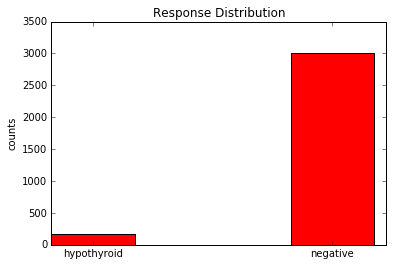

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline
print("Histograms below: ")

responses = df.groupBy('Result').count().collect() #list of rows
categories = [i[0] for i in responses]
counts =[i[1] for i in responses]

ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color ='r')

plt.ylabel('counts')
plt.title('Response Distribution')
plt.xticks(ind + width/2., categories)




In [69]:
cols_select = ['age', 'TSH','T3','TT4','T4U','FTI','on_thyroxine','query_on_thyroxine', 'thyroid_surgery','query_hypothyroid',
               'query_hyperthyroid','pregnant','sick','goitre','Result']

df = df.select(df.age.cast('int'),
               df.TSH.cast('float'),
               df.T3.cast('float'),
               df.TT4.cast('float'),
               df.T4U.cast('float'),
               df.FTI.cast('float'),
               *cols_select[6:])


In [70]:
for col in df.columns[6:-2]:
    print(col,df.select(col).distinct().count())

('on_thyroxine', 2)
('query_on_thyroxine', 2)
('thyroid_surgery', 2)
('query_hypothyroid', 2)
('query_hyperthyroid', 2)
('pregnant', 2)
('sick', 2)


In [71]:
#convert categorical values to numerical form, so your model can tree them. One way is to use integer to represent. 

column_vec_in = ['on_thyroxine','query_on_thyroxine', 'thyroid_surgery','query_hypothyroid',
               'query_hyperthyroid','pregnant','sick','goitre' ]

#chose the column name that it will be converted to
column_vec_out= ['on_thyroxine_vec','query_on_thyroxine_vec', 'thyroid_surgery_vec','query_hypothyroid_vec',
               'query_hyperthyroid_vec','pregnant_vec','sick_vec','goitre_vec']

indexers = [StringIndexer(inputCol=x, outputCol=x+'_tmp') for x in column_vec_in]

#the output from the string indexer will pass into the encoder

encoders = [OneHotEncoder(dropLast=False, inputCol =x+"_tmp", outputCol=y)
           for x,y in zip(column_vec_in, column_vec_out)]

tmp =[[i,j]for i,j in zip(indexers, encoders)]
tmp = [i for sublist in tmp for i in sublist]



In [73]:
# let your model know which columns to model on and then put the result into.

cols_now = ['age', 
            'TSH',
            'T3',
            'TT4',
            'T4U',
            'FTI',
            'on_thyroxine_vec',
            'query_on_thyroxine_vec', 
            'thyroid_surgery_vec',
            'query_hypothyroid_vec',
            'query_hyperthyroid_vec',
            'pregnant_vec',
            'sick_vec',
            'goitre_vec']

#input is the list of the names of the columns that you want to use as predictors.
#specify the output column 'features', the second step is to create a string indexer function
#you specify the output column names label
assembler_features = VectorAssembler(inputCols=cols_now, outputCol='tests')
labelIndexer = StringIndexer(inputCol='Result', outputCol = 'predict')
tmp +=[assembler_features, labelIndexer]
pipeline = Pipeline(stages=tmp)

In [74]:
allData = pipeline.fit(df).transform(df)
#Don't want pyspark to redo sampling again, so cache the data in memory
allData.cache()
#here is where we do the split 80% train and 20% testing
trainingData, testData = allData.randomSplit([0.8,0.2], seed = 0) #need to ensure same split for each time
print("Distribution of HypoThyroid and Neg in trainingData is: ", trainingData.groupBy('predict').count().take(3))

('Distribution of HypoThyroid and Neg in trainingData is: ', [Row(predict=1.0, count=136), Row(predict=0.0, count=2386)])


In [75]:
#train and predict

rf = RF(labelCol='predict', featuresCol='tests', numTrees=50)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)


In [77]:
#label = predict
#features = tests
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed.select(['probability','predict'])
#prepare score-predict set
results_collect = results.collect()
results_list = [(float(i[0][0]),1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("The ROC score is (@numTrees=50):", metrics.areaUnderROC)


('The ROC score is (@numTrees=50):', 0.9974782084315551)


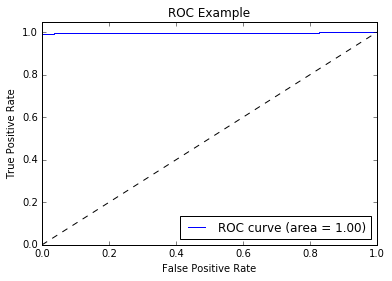

In [83]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in results_list]
y_score =  [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Example')
plt.legend(loc="lower right")
plt.show()

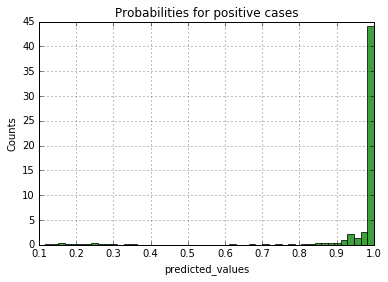

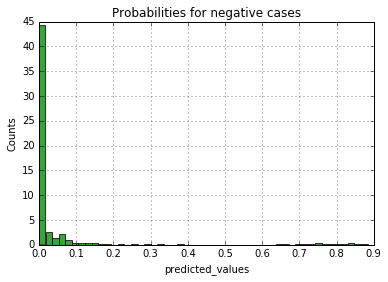

In [85]:
all_probs = transformed.select("probability").collect()
pos_probs = [i[0][0] for i in all_probs]
neg_probs = [i[0][1] for i in all_probs]

from matplotlib import pyplot as plt
%matplotlib inline

#pos
plt.hist(pos_probs, 50, normed =1, facecolor ='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for positive cases')
plt.grid(True)
plt.show()

#neg
plt.hist(neg_probs, 50, normed =1, facecolor ='green', alpha=0.75)
plt.xlabel('predicted_values')
plt.ylabel('Counts')
plt.title('Probabilities for negative cases')
plt.grid(True)
plt.show()

In [90]:
#Down - sampling

from numpy.random import randint
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

RATIO_ADJUST = 2.0 # ratio of positive to negative in the df_subsample

counts = trainingData.select('Result').groupBy('Result').count().collect()
higherBound = counts[0][1]
THESHOLD_TO_FILTER = int(RATIO_ADJUST * float(counts[1][1]/ counts [0][1] *higherBound))

randGen = lambda x: randint(0, higherBound) if x == "hypothyroid" else -1

udfRandGen = udf(randGen, IntegerType())
trainingData = trainingData.withColumn("randIndex", udfRandGen("Result"))
df_subsample = trainingData.filter(trainingData['randIndex'] <THESHOLD_TO_FILTER)
df_subsample = df_subsample.drop('randIndex')

print("Distribution of Pos and Neg cases of the down-sample training data are: \n", df_subsample.groupBy('Result').count().collect())



('Distribution of Pos and Neg cases of the down-sample training data are: \n', [Row(Result=u'hypothyroid', count=136), Row(Result=u'negative', count=2386)])
